# Gaussian Mixture Models Example

In [1]:
!pip install geopandas

In [2]:
!pip install opencv-python

In [3]:
!pip install tqdm

In [4]:
from time import sleep
from tqdm import tqdm
import sklearn
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from numpy import asarray
import os
from os.path import isfile, join
import glob
import cv2
import PIL.Image
import matplotlib.image

In [5]:
pwd

'/home/jovyan/MP1'

## Loading and reducing the data

### Loading The Data

**Initialize Important Variables**

In [6]:
#Create string variable to store directory of images
pwd=os.getcwd()
Folder='/CatMotion/*.jpg'
dirString=pwd+Folder
print("pwd =",dirString)

#Create variable to show number of images
imgTotal=len(glob.glob(dirString))

#Create String variables to be used in for loop to load in images
name='CatMotion'
picDir=pwd+'/'+name+'/'
ext='ss.jpg'

#Load test image
i=8
num=str(i+1)
call=picDir+name+num+ext
print('call:',call)
image = PIL.Image.open(call)

#Find size of images
width, height = image.size
x=height
y=width
print("Image Width:", width,"; Image Height:", height)

#Create labels for each image
labels=[str(i+1) for i in range(24)]
print(labels)

#Set variables to be used with array indices and means
columns=width*height
rows=imgTotal
axisNum=1 #axis=1, work along the rows, axis=0, work along the rows

pwd = /home/jovyan/MP1/CatMotion/*.jpg
call: /home/jovyan/MP1/CatMotion/CatMotion9ss.jpg
Image Width: 80 ; Image Height: 45
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']


**Create Empty Array to Store Flattened B&W Image Data**

In [7]:
images = np.zeros((columns, rows), int)
print("Size of Empty Array:",images.shape)

Size of Empty Array: (3600, 24)


**Test of Converting Image File to NumPy Array**

In [8]:
#Load test image
#i=0
#num=str(i+1)
#call=picDir+name+num+ext
#image = PIL.Image.open(call)

#Find size of image
#width, height = image.size
#print("Image Width: ", width,"Image Height:", height)

#Flatten Grayscale image to true B&W image
#image = image.convert('L')

#Convert B&W image to numpy array
#image=asarray(image)

#Flatten B&W image array to 1-dimensional array
#(This helps store the image in the "images" array)
#image=image.flatten()

#Store Flattened B&W image to "images" array
#images[:,i]=image[:,]

#Plot reshaped flattened image from "images" array (CONVERSION FINISHED)
#plt.imshow(images[:,0].reshape(x,y))

**Convert All Images to "Images" Array**

In [9]:
for i in range(imgTotal):
#    print(i) #debugging code
    num=str(i+1)
    call=picDir+name+num+ext
#    print(call) #debugging code
    imgtmp=PIL.Image.open(call)
    imgtmp=imgtmp.convert('L')
    imgtmp=asarray(imgtmp)
    imgtmp=imgtmp.flatten()
    images[:,i]=imgtmp[:,]
print("Shape of Images Array:",images.shape)

Shape of Images Array: (3600, 24)


**Test Saving Array to Image**

In [10]:
#matplotlib.image.imsave('test2.jpg', images[:,2-1].reshape(height,width))

**Test Saving Plot to Image**

In [11]:
#plt.imshow(images[:,imgTotal-1].reshape(x,y), cmap='gray')
#plt.savefig('test.jpg', dpi=240, bbox_inches='tight')
#plt.show,images.shape

**Centering the Data**

In [12]:
#Compute the mean of the axis
meanData=images.mean(axisNum, keepdims=True)
centeredData = images - meanData
print("Centered Data Shape:",centeredData.shape)

Centered Data Shape: (3600, 24)


**Display First Image of Centered Data**

<function matplotlib.pyplot.show(close=None, block=None)>

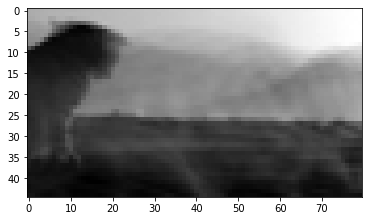

In [13]:
plt.imshow(meanData[:,0].reshape(x,y),cmap='gray')
#plt.savefig('MP2Figures/meanData.jpg', dpi=240, bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

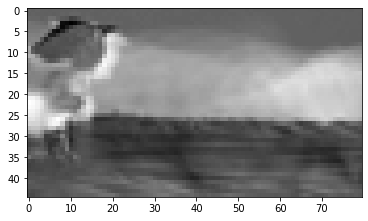

In [14]:
plt.imshow(centeredData[:,0].reshape(x,y),cmap='gray')
#plt.savefig('MP2Figures/CenteredData.jpg', dpi=240, bbox_inches='tight')
plt.show

### Reducing The Data

In [15]:
pca=PCA(n_components=2)
#transpose to make individual images the features
data_matrix=pca.fit_transform(centeredData.T)
print('Reduced Data Shape:',data_matrix.shape)

Reduced Data Shape: (24, 2)


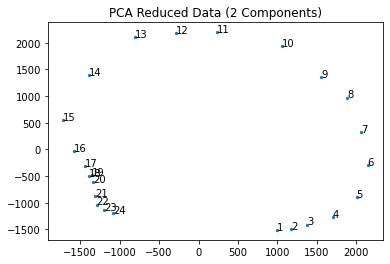

In [16]:
plt.scatter(
    data_matrix[:,0],
    data_matrix[:,1],
    s=5
)
for i in range(24):
    plt.annotate(labels[i],(data_matrix[i,0],data_matrix[i,1]))
plt.title('PCA Reduced Data (2 Components)')
plt.savefig('MP2Figures/PCAReducedData.jpg', dpi=240, bbox_inches='tight')
plt.show()

## Define Functions

In [17]:
def update_pi_list(mu_list, sigma_list, pi_list, X, responsibilities):
    new_pi_list = []
    K = len(mu_list)
    N = len(X)
    for k in range(K):
        new_pi_k = np.sum(responsibilities[:,k])/N
        new_pi_list.append(new_pi_k)
    return new_pi_list

def get_responsibilities(mu_list, sigma_list, pi_list, X):
    #first compute the numerators
    K = len(mu_list)
    N = len(X)
    r = np.zeros((N,K))
    for n in range(N):
        for k in range(K):            
            #compute pi_k*N(x_n | mu_k, sigma_k)
            r[n,k] = pi_list[k]*1/(2*np.pi)*np.linalg.det(sigma_list[k])**(-0.5)*np.exp(
                -0.5*(X[n]-mu_list[k])@np.linalg.inv(sigma_list[k])@(X[n]-mu_list[k]).T
            )
    #now divide each row by its sum to account for the denominator
    r = r/r.sum(axis=1, keepdims=True)
    return r

def update_mu_list(mu_list, sigma_list, pi_list, X, responsibilities):
    new_mu_list = []
    K = len(mu_list)
    for k in range(K):
        new_mu_k = responsibilities[:,k]@X / np.sum(responsibilities[:,k])
        new_mu_list.append(new_mu_k)
    return new_mu_list

def update_sigma_list(mu_list, sigma_list, pi_list, X, responsibilities):
    new_sigma_list = []
    K = len(mu_list)
    N = len(X)
    for k in range(K):
        new_sigma_k = sum([
            responsibilities[n,k]*np.outer(X[n,:]-mu_list[k], X[n,:]-mu_list[k]) for n in range(N)
        ])/np.sum(responsibilities[:,k])
        new_sigma_list.append(new_sigma_k)
    return new_sigma_list

#### Log Likelihood Function

$$\log(L)=\sum^{k}_{k=24}\log(\textrm{pdf}(x_{n},y_{n}))$$

In [ ]:
from scipy.stats import multivariate_normal
def logpdf(x, y, mu_list, sigma_list, pi_list):
    K = len(pi_list)
    L = sum(pi_list[k]*multivariate_normal(mu_list[k], sigma_list[k]).pdf([x,y]) for k in range(K))
    return np.log(L)

## ***BIG FOR-LOOP***


0. kVal = 1 , INITIALIZING...

1. kVal = 1 , CREATING LISTS...

2. kVal = 1 , CHECK LISTS...
mu_list length: 1 
sigma_list length: 1 
pi_list length: 1 
r (24, 1)

3. kVal = 1 
RUN EXPECTATION MAXIMIZATION (EM) ALGORITHM:
EM converged after  1  steps

4. kVal = 1 
Components and Means


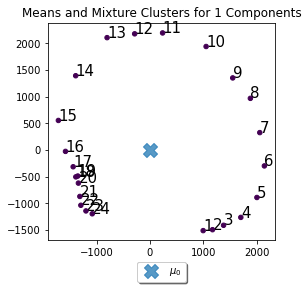

5. kVal = 1 
Components Colored by Responsibility


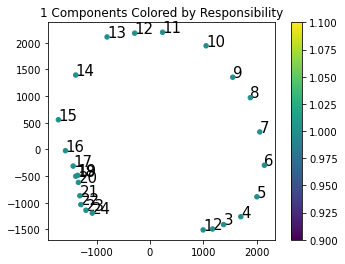

6. AIC AND BIC STUFF...
TEST: -413.52876207288324 1

7. kVal = 1 
CONTOUR PLOT FOR 1 COMPONENTS:


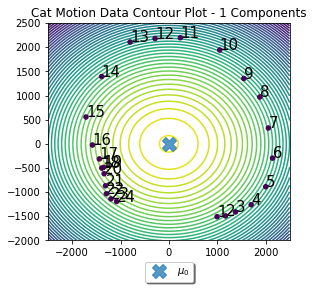


0. kVal = 2 , INITIALIZING...

1. kVal = 2 , CREATING LISTS...

2. kVal = 2 , CHECK LISTS...
mu_list length: 2 
sigma_list length: 2 
pi_list length: 2 
r (24, 2)

3. kVal = 2 
RUN EXPECTATION MAXIMIZATION (EM) ALGORITHM:
EM converged after  163  steps

4. kVal = 2 
Components and Means


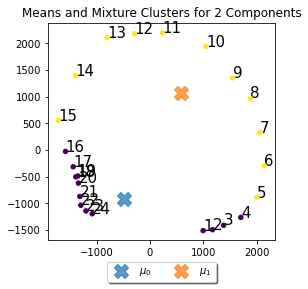

5. kVal = 2 
Components Colored by Responsibility


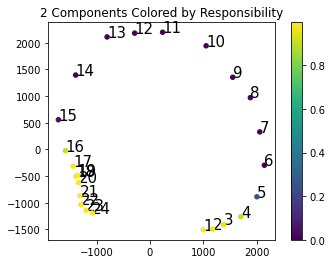

6. AIC AND BIC STUFF...
TEST: -404.8885394656095 2

7. kVal = 2 
CONTOUR PLOT FOR 2 COMPONENTS:


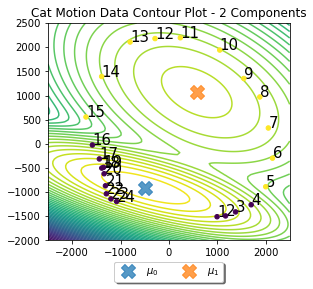


0. kVal = 3 , INITIALIZING...

1. kVal = 3 , CREATING LISTS...

2. kVal = 3 , CHECK LISTS...
mu_list length: 3 
sigma_list length: 3 
pi_list length: 3 
r (24, 3)

3. kVal = 3 
RUN EXPECTATION MAXIMIZATION (EM) ALGORITHM:
EM converged after  33  steps

4. kVal = 3 
Components and Means


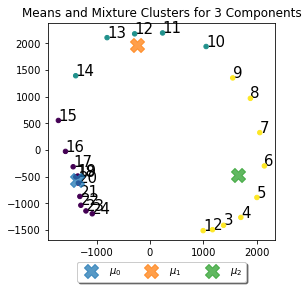

5. kVal = 3 
Components Colored by Responsibility


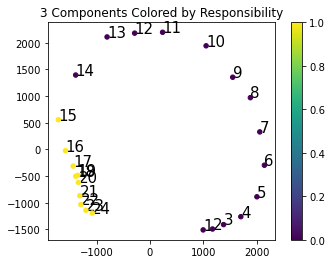

6. AIC AND BIC STUFF...
TEST: -370.0148059088667 3

7. kVal = 3 
CONTOUR PLOT FOR 3 COMPONENTS:


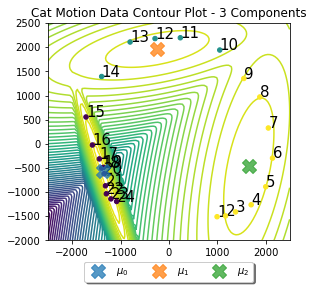


0. kVal = 4 , INITIALIZING...

1. kVal = 4 , CREATING LISTS...

2. kVal = 4 , CHECK LISTS...
mu_list length: 4 
sigma_list length: 4 
pi_list length: 4 
r (24, 4)

3. kVal = 4 
RUN EXPECTATION MAXIMIZATION (EM) ALGORITHM:
EM converged after  26  steps

4. kVal = 4 
Components and Means


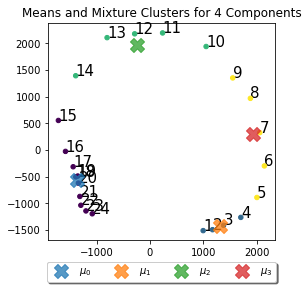

5. kVal = 4 
Components Colored by Responsibility


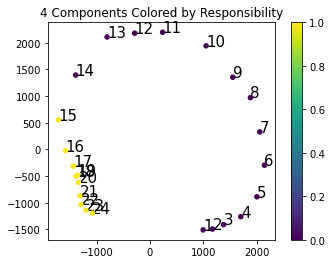

6. AIC AND BIC STUFF...
TEST: -353.50985181000476 4

7. kVal = 4 
CONTOUR PLOT FOR 4 COMPONENTS:


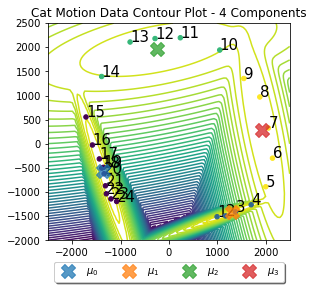

In [39]:
COLUMNSIZE=data_matrix.shape[0]
AICTable=np.zeros(COLUMNSIZE)
BICTable=np.zeros(COLUMNSIZE)
for COMPONENTNUMBER in range(1,5,1):
    if COMPONENTNUMBER<5:
        SMOL=1e-8
        RUNCHECK=1
    elif COMPONENTNUMBER==5:
        SMOL=1e-3
        RUNCHECK=0
    elif COMPONENTNUMBER==6:
        SMOL=1e-1
        RUNCHECK=0
    elif COMPONENTNUMBER>=7:
        SMOL=.5
    kVal=COMPONENTNUMBER
    if kVal<10:
        kOut=str(0)+str(kVal)
    else:
        kOut=str(kVal)
    print('\n0. kVal =', kVal, ', INITIALIZING...')
    MAXSTEPS=250
    mu_list=[]
    sigma_list=[]
    pi_list=[]
    
    print('\n1. kVal =', kVal, ', CREATING LISTS...')
    for k in range(kVal):
        mu_list.append(data_matrix[k])
        sigma_list.append(np.cov(data_matrix.T))
        pi_list.append(1/(kVal))
    r = get_responsibilities(
        mu_list, sigma_list, pi_list, data_matrix
        )
    
    if RUNCHECK==1:
        #print('mu_list:\n', mu_list, '\nlength:', len(mu_list),'\n','\nsigma_list:\n',sigma_list, '\nlength:', len(sigma_list), '\n','\npi_list:\n', pi_list, '\nlength:', len(pi_list), '\n','\nr', r.shape)
        #Just the shapes:
        print('\n2. kVal =', kVal, ', CHECK LISTS...\nmu_list length:', len(mu_list),'\nsigma_list length:', len(sigma_list),'\npi_list length:', len(pi_list),'\nr', r.shape)

    print('\n3. kVal =', kVal, '\nRUN EXPECTATION MAXIMIZATION (EM) ALGORITHM:')
    for step in range(MAXSTEPS): #TQDM REMOVED
        #get updates
        mu_list = update_mu_list(
            mu_list, sigma_list, pi_list, data_matrix, r
        )
        sigma_list = update_sigma_list(
            mu_list, sigma_list, pi_list, data_matrix, r
        )
        pi_list = update_pi_list(
            mu_list, sigma_list, pi_list, data_matrix, r
        )
        #get responsibilities
        new_r = get_responsibilities(
            mu_list, sigma_list, pi_list, data_matrix
        )
        #check for convergence
        if np.max(np.abs(r - new_r)) < SMOL:
            print('EM converged after ', step+1, ' steps')
            break    
        else:
            r = new_r

    if RUNCHECK==1:
        #PLOT A BUNCH OF STUFF
        print('\n4. kVal =', kVal, '\nComponents and Means')
        best_component = np.argmax(r, axis=1)
        plt.scatter(
            data_matrix[:,0],
            data_matrix[:,1],
            alpha=1,
            s=20,
            c=best_component,
            zorder=2
        )
        for k in range(kVal):
            plt.scatter(
                [mu_list[k][0]],
                [mu_list[k][1]],
                marker='X',
                alpha=0.75,
                s=200,
                label='$\mu_{{{:2d}}}$'.format(k),
                zorder=3
            )
        for i in range(24):
            plt.annotate(labels[i],(data_matrix[i,0],data_matrix[i,1]), fontsize=15, zorder=1)
        legend1=plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.075),
                           fancybox=True, shadow=True, ncol=kVal)
        plt.gca().add_artist(legend1)
        plt.gca().set_aspect(1)
        plt.title('Means and Mixture Clusters for '+str(kVal)+' Components')
        plt.savefig('MP2Figures/'+kOut+' 1 - Mean Overlay.jpg', dpi=240, bbox_inches='tight')
        plt.show()
        print('5. kVal =', kVal, '\nComponents Colored by Responsibility')
        plt.scatter(
            data_matrix[:,0],
            data_matrix[:,1],
            c=r[:,0],
            alpha=1,
            s=20,
            zorder=2
        )
        for i in range(24):
            plt.annotate(labels[i],(data_matrix[i,0],data_matrix[i,1]), fontsize=15, zorder=1)
        plt.colorbar()
        plt.gca().set_aspect(1)
        plt.title(str(kVal)+' Components Colored by Responsibility')
        plt.savefig('MP2Figures/'+kOut+' 2 - Components Responsibility.jpg', dpi=240, bbox_inches='tight')
        plt.show()
    
    print('6. AIC AND BIC STUFF...')
    
    #X = np.linspace(-1600, 2200, 100)
    #Y = np.linspace(-1600, 2200, 100)

    #XX, YY = np.meshgrid(X, Y)
    #rows, cols = XX.shape
    #p=kVal #variable length of number of best components to use
    #k=(2*p)+(3*p)+(p-1) #Number of parameters from model
    n=COLUMNSIZE
    
    PreSumL=[logpdf(data_matrix[i,0], data_matrix[i,1], mu_list, sigma_list, pi_list) for i in range(n)]
    SumL=np.sum(PreSumL)
    SumL
    print('TEST:', SumL, kVal)
    
    AIC=2*(2*kVal+3*kVal+kVal-1)-2*SumL
#    AIC=2*kVal-2*SumL
    AICTable[kVal]=AIC
    
    BIC=(2*kVal+3*kVal+kVal-1)*np.log(n)-2*SumL 
#    BIC=kVal*np.log(n)-2*SumL
    BICTable[kVal]=BIC

    if RUNCHECK==1:
        print('\n7. kVal =', kVal, '\nCONTOUR PLOT FOR', kVal, 'COMPONENTS:')
        X = np.linspace(-2500, 2500, 100)
        Y = np.linspace(-2000, 2500, 100)

        XX, YY = np.meshgrid(X, Y)
        rows, cols = XX.shape

        Z= np.array(
            [
                [
                    logpdf(XX[i,j], YY[i,j], mu_list, sigma_list, pi_list) for j in range(cols)
                ] for i in range(rows) #TQDM REMOVED
            ]
        )

        plt.scatter(
            data_matrix[:,0],
            data_matrix[:,1],
            alpha=1,
            s=20,
            c=best_component,
            zorder=3
        )
        for k in range(kVal):
            plt.scatter(
                [mu_list[k][0]],
                [mu_list[k][1]],
                marker='X',
                alpha=0.75,
                s=200,
                label='$\mu_{{{:2d}}}$'.format(k),
                zorder=4
            )
        for i in range(24):
            plt.annotate(labels[i],(data_matrix[i,0],data_matrix[i,1]), fontsize=15, zorder=2)
        legend1=plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.075),
                           fancybox=True, shadow=True, ncol=kVal)
        plt.contour(
            XX, YY,Z, levels=50, zorder=1
        )
        plt.gca().add_artist(legend1)
        plt.gca().set_aspect(1)
        plt.title('Cat Motion Data Contour Plot - '+str(kVal)+' Components')
        plt.savefig('MP2Figures/'+kOut+' 3 - Contour Plot.jpg', dpi=240, bbox_inches='tight')
        plt.show()

### Compare AIC and BIC

$$AIC=2k-2ln(\hat{L})$$

$$BIC=kln(n)-2ln(\hat{L})$$

In [21]:
#Criterion Table Values
AICPlot=[]
BICPlot=[]
if len(AICPlot)==len(BICPlot):
    for i in range(1,COLUMNSIZE,1):
        AICPlot.append(AICTable[i])
        BICPlot.append(BICTable[i])
        print(i,'components:\nAIC =',AICTable[i],'| BIC =',BICTable[i],'\n')
else:
    print('ERROR: len(AICTable)!=len(BICTable)')  
#print('AICTable', AICTable.shape)
#print('BICTable', BICTable.shape)

1 components:
AIC = 837.0575241457665 | BIC = 842.9477932975062 

2 components:
AIC = 831.777078931219 | BIC = 844.7356710650464 

3 components:
AIC = 774.0296118177334 | BIC = 794.0565269336486 

4 components:
AIC = 753.0197036200095 | BIC = 780.1149417180122 

5 components:
AIC = 738.4932410627255 | BIC = 772.6568021428159 

6 components:
AIC = 896.0506457724431 | BIC = 937.2825298346212 

7 components:
AIC = 906.4708962984428 | BIC = 954.7711033427086 

8 components:
AIC = 916.2667249056065 | BIC = 971.6352549319599 

9 components:
AIC = 926.6629490719413 | BIC = 989.0998020803825 

10 components:
AIC = 937.1865447287854 | BIC = 1006.6917207193142 

11 components:
AIC = 948.1813005559128 | BIC = 1024.7547995285292 

12 components:
AIC = 959.6105895871326 | BIC = 1043.2524115418369 

13 components:
AIC = 971.0522336205975 | BIC = 1061.7623785573892 

14 components:
AIC = 981.2925210186837 | BIC = 1079.0709889375632 

15 components:
AIC = 989.2280289500247 | BIC = 1094.0748198509918 


In [22]:
print('AICPlot Length:',len(AICPlot))
print('BICPlot Length:',len(BICPlot))
if len(AICPlot)==len(BICPlot):
    CriterionRange=len(AICPlot)
else:
    print('ERROR: len(AICPlot)!=len(BICPlot)')

AICPlot Length: 23
BICPlot Length: 23


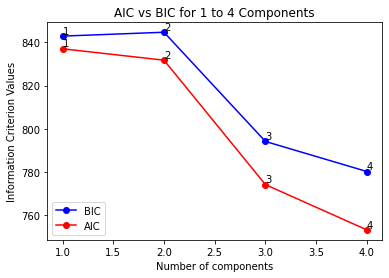

In [23]:
CriterionRange=4
plotlabels=[str(i) for i in range(24)]
fig, ax = plt.subplots()
ax.plot(range(1,CriterionRange+1,1),BICPlot[0:CriterionRange],c='blue', marker="o", label='BIC')
ax.plot(range(1,CriterionRange+1,1),AICPlot[0:CriterionRange],c='red', marker="o", label='AIC')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion Values')
plt.title('AIC vs BIC for '+str(1)+' to '+str(CriterionRange)+' Components')
tmp=range(COLUMNSIZE)
for i in range(0,CriterionRange+1,1):
    ax.annotate(plotlabels[i],(tmp[i],BICPlot[i-1]+1))
    ax.annotate(plotlabels[i],(tmp[i],AICPlot[i-1]+1))
legend=ax.legend()
ax.legend(loc='lower left', frameon=True)
plt.savefig('MP2Figures/AICvsBIC '+str(1)+' to '+str(CriterionRange)+' Components.jpg', dpi=240, bbox_inches='tight')
plt.show()

In [24]:
#numerical issues more than 5 components

### 3 Components:

In [25]:
#initialize
MAXSTEPS=150
mu_list = [data_matrix[0], data_matrix[1], data_matrix[2]]
sigma_list = [np.cov(data_matrix.T), np.cov(data_matrix.T), np.cov(data_matrix.T)]
pi_list = [1/3, 1/3, 1/3]
r = get_responsibilities(
        mu_list, sigma_list, pi_list, data_matrix
    )

#run EM
for step in tqdm(range(MAXSTEPS)):
    #get updates
    mu_list = update_mu_list(
        mu_list, sigma_list, pi_list, data_matrix, r
    )
    sigma_list = update_sigma_list(
        mu_list, sigma_list, pi_list, data_matrix, r
    )
    pi_list = update_pi_list(
        mu_list, sigma_list, pi_list, data_matrix, r
    )
    #get responsibilities
    new_r = get_responsibilities(
        mu_list, sigma_list, pi_list, data_matrix
    )
    #check for convergence
    if np.max(np.abs(r - new_r)) < 1e-8:
        print('EM converged after ', step+1, ' steps')
        break    
    else:
        r = new_r

 21%|██▏       | 32/150 [00:01<00:06, 18.83it/s]

EM converged after  33  steps


In [26]:
mu_list[1]

array([-238.4838002 , 1963.44883542])

## Looking at the results

### a. Scatter plot with means

We can borrow our code from Notebook 9 for this part.

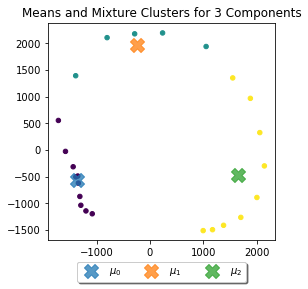

In [27]:
kVal=3
best_component = np.argmax(r, axis=1)
plt.scatter(
    data_matrix[:,0],
    data_matrix[:,1],
    alpha=1,
    s=20,
    c=best_component
)
for k in range(kVal):
    plt.scatter(
        [mu_list[k][0]],
        [mu_list[k][1]],
        marker='X',
        alpha=0.75,
        s=200,
        label='$\mu_{{{:2d}}}$'.format(k)
    )
legend1=plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.075),
                  fancybox=True, shadow=True, ncol=kVal)
plt.gca().add_artist(legend1)
plt.gca().set_aspect(1)
plt.title('Means and Mixture Clusters for '+str(kVal)+' Components')
#plt.savefig('MP2Figures/'+kOut+' 1 - Mean Overlay.jpg', dpi=240, bbox_inches='tight')
plt.show()

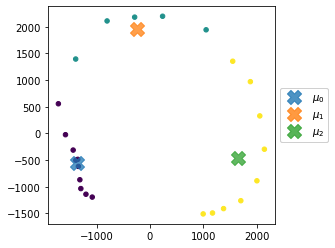

In [28]:
kVal=3
best_component = np.argmax(r, axis=1)
fig, ax = plt.subplots()
ax.scatter(
    data_matrix[:,0],
    data_matrix[:,1],
    alpha=1,
    s=20,
    c=best_component
)
for k in range(kVal):
    ax.scatter(
        [mu_list[k][0]],
        [mu_list[k][1]],
        marker='X',
        alpha=0.75,
        s=200,
        label='$\mu_{{{:2d}}}$'.format(k)
    )   
legend1=ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.gca().add_artist(legend1)
plt.gca().set_aspect(1)
#plt.savefig('MP2Figures/'+str(kVal)+' Best Components - Mean Overlay.jpg', dpi=240, bbox_inches='tight')
plt.show()

### b. Assigning mixture components

Let's ask each point which mixture component has the highest responsibility, and color the dots by that assignment.

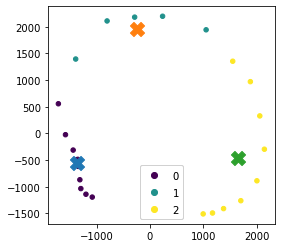

In [29]:
scatter = plt.scatter(
    data_matrix[:,0],
    data_matrix[:,1],
    alpha=1,
    s=20,
    c=best_component,
    label=best_component
)
for k in range(kVal):
    plt.scatter(
        [mu_list[k][0]],
        [mu_list[k][1]],
        marker='X',
        s=200,
        label='mu_'+str(k)
    )
legend1 = plt.gca().legend(*scatter.legend_elements())
plt.gca().add_artist(legend1)
plt.gca().set_aspect(1)
plt.show()

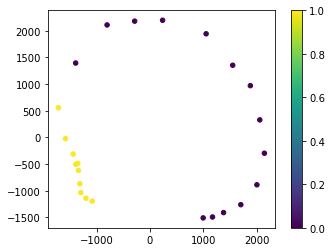

In [30]:
#fig, bx = plt.subplots()
plt.scatter(
    data_matrix[:,0],
    data_matrix[:,1],
    c=r[:,0],
    alpha=1,
    s=20
) 
plt.colorbar()
plt.gca().set_aspect(1)
#plt.savefig('ResponsibilityColor.jpg', dpi=240, bbox_inches='tight')
plt.show()

### c. Contour plots

To see the distribution, we can make contour plots. Let's do that now, adapting from Notebook 9.

In [31]:
X = np.linspace(-2500, 2500, 100)
Y = np.linspace(-2000, 2500, 100)

XX, YY = np.meshgrid(X, Y)
rows, cols = XX.shape

Z= np.array(
    [
        [
            logpdf(XX[i,j], YY[i,j], mu_list, sigma_list, pi_list) for j in range(cols)
        ] for i in tqdm(range(rows))
    ]
)

100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


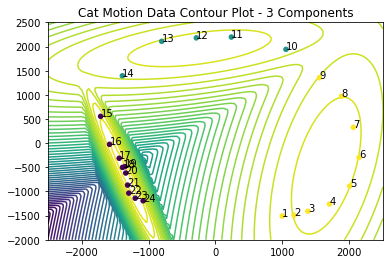

In [36]:
plt.scatter(
    data_matrix[:,0],
    data_matrix[:,1],
    alpha=1,
    s=20,
    c=best_component,
    zorder=2
)
plt.contour(
    XX, YY,Z, levels=50, zorder=1
)
for i in range(24):
    plt.annotate(labels[i],(data_matrix[i,0],data_matrix[i,1]))
plt.title('Cat Motion Data Contour Plot - 3 Components')
#plt.savefig('Contour - 3 Components.jpg', dpi=240, bbox_inches='tight')
plt.show()

In [33]:
pi_list

[0.41666639770271213, 0.2082424727857837, 0.3750911295115042]

~41% in act 1

In [39]:
sigma_list[0]

array([[1531751.59996774,  -36765.42840218],
       [ -36765.42840218,  505839.18521926]])

## d. Confidence intervals

To find confidence intervals for the $x$ marginal, we need the weights, marginal mean and variance for each component. Using Equation (6.68) in the book, we see that we just need to take the right entries in $\mu_1$ and $\Sigma_1$.

In [107]:
means_x = [mu_list[0][0], mu_list[1][0], mu_list[2][0]]
vars_x = [sigma_list[0][0,0], sigma_list[1][0,0],sigma_list[2][0,0]]

In [108]:
means_x

[-1370.3836311820207, -238.48380019649963, 1654.6786061194546]

In [31]:
np.sqrt(vars_x)

array([171.0315475 , 841.70907559, 384.57887533])

In [118]:
means_y = [mu_list[0][1], mu_list[1][1], mu_list[2][1]]
vars_y = [sigma_list[0][1,1], sigma_list[1][1,1],sigma_list[2][1,1]]

In [119]:
means_y

[-561.8074575680339, 1963.4488354283244, -465.9858295195787]

In [120]:
np.sqrt(vars_y)

array([ 515.92927628,  298.89275106, 1047.61255906])

In [32]:
pi_list

[0.4166663977027134, 0.2082424727857163, 0.37509112951157036]

To find a confidence interval, we find two values, $u$ and $v$ such that
$$
\pi_1 \Phi(u | \mu_{x1}, \sigma_{x1})  + \pi_2 \Phi(u | \mu_{x2}, \sigma_{x2})  = 0.025
$$
and
$$
\pi_1 \Phi(v \mid \mu_{x1}, \sigma_{x1})  + \pi_2 \Phi(v \mid \mu_{x2}, \sigma_{x2})  = 0.975
$$
where $\Phi$ is the cdf of the Gaussian distribution, $\mu_{x1},\ \mu_{x2}$ are the means of the components for the $x$ marginal and  $\sigma_{x1},\ \sigma_{x2}$ are the variances. The confidence interval will then be $[u,v]$, since we know that the integral of the pdf over this interval is $0.95$.

To find the $u$ and $v$, we can use the formula for $\Phi$ in terms of the error function $\mathsf{erf}$ and then give it to WolframAlpha (or another program) to solve. Whatever values we get, it should make sense when we look at this histogram representing the $x$ marginal.

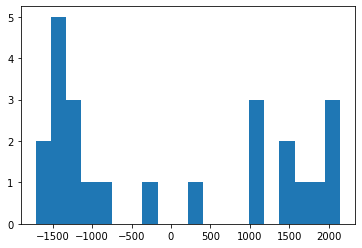

In [137]:
plt.hist(
    data_matrix[:,0],
    bins=20
)
plt.show()

When I did it, I put the following into WolframAlpha:

`solve for u 0.025 = 0.366*0.5*(1+erf((u-1164339)/(sqrt(2)*540141))) + 0.634*0.5*(1+erf((u+819400)/(sqrt(2)*1183822)))`

and got $u = -2.899\cdot 10^6$. Similarly, I got $v = 2.031 \cdot 10^6$. Putting these as lines on the histogram, it looks reasonable.

-1370.3836311820885, -238.48380019653794, 1654.6786061193554

171.0315475, 841.70907559, 384.57887533

$$ 0.025 = 0.417*0.5*\bigg(1+\text{erf}\bigg(\frac{u-(-1370.384)}{\sqrt{2}*171.031}\bigg)\bigg) + 0.208*0.5*\bigg(1+\text{erf}\bigg(\frac{u-(-238.484)}{\sqrt{2}*841.709}\bigg)\bigg)+ 0.375*0.5*\bigg(1+\text{erf}\bigg(\frac{u-1654.679}{\sqrt{2}*384.579}\bigg)\bigg)$$

$$u=-1673.9$$

$$ 0.975 = 0.417*0.5*\bigg(1+\text{erf}\bigg(\frac{v-(-1370.384)}{\sqrt{2}*171.031}\bigg)\bigg) + 0.208*0.5*\bigg(1+\text{erf}\bigg(\frac{v-(-238.484)}{\sqrt{2}*841.709}\bigg)\bigg)+ 0.375*0.5*\bigg(1+\text{erf}\bigg(\frac{v-1654.679}{\sqrt{2}*384.579}\bigg)\bigg)$$

$$v=2248.55$$

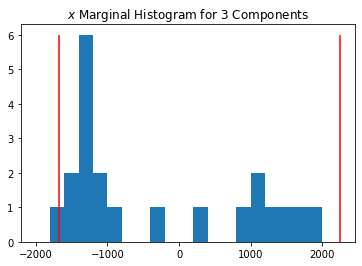

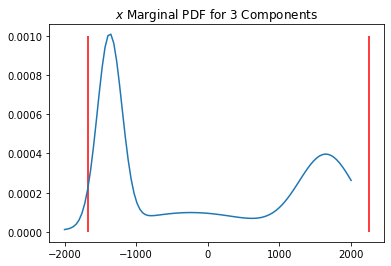

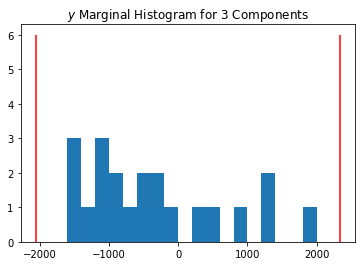

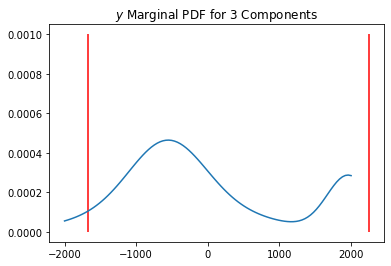

In [121]:
#X MARGINAL HISTOGRAM
plt.hist(
    data_matrix[:,0],
    bins=20,
    range=(-2000,2000)
)
plt.vlines(-1673.79, 0, 6, color='red')
plt.vlines(2248.55, 0, 6, color='red')
plt.title('$x$ Marginal Histogram for 3 Components')
plt.savefig('MP2Figures/x Marginal Histogram.jpg', dpi=240, bbox_inches='tight')
plt.show()
from scipy.stats import norm
#X MARGINAL PDF
X = np.linspace(-2000, 2000, 100)
Y = [sum(pi_list[i]*norm.pdf(x, loc=means_x[i], scale=np.sqrt(vars_x[i])) for i in range(3)) for x in X]
plt.plot(
    X,Y
)
plt.vlines(-1673.79, 0, 0.001, color='red')
plt.vlines(2248.55, 0, 0.001, color='red')
plt.title('$x$ Marginal PDF for 3 Components')
plt.savefig('MP2Figures/x Marginal PDF.jpg', dpi=240, bbox_inches='tight')
plt.show()
#Y MARGINAL HISTOGRAM
plt.hist(
    data_matrix[:,1],
    bins=20,
    range=(-2000,2000)
)
plt.vlines(-2054.47, 0, 6, color='red')
plt.vlines(2338.25, 0, 6, color='red')
plt.title('$y$ Marginal Histogram for 3 Components')
plt.savefig('MP2Figures/y marginal.jpg', dpi=240, bbox_inches='tight')
plt.show()
#Y MARGINAL PDF
X = np.linspace(-2000, 2000, 100)
Y = [sum(pi_list[i]*norm.pdf(x, loc=means_y[i], scale=np.sqrt(vars_y[i])) for i in range(3)) for x in X]
plt.plot(
    X,Y
)
plt.vlines(-1673.79, 0, 0.001, color='red')
plt.vlines(2248.55, 0, 0.001, color='red')
plt.title('$y$ Marginal PDF for 3 Components')
plt.savefig('MP2Figures/y Marginal PDF.jpg', dpi=240, bbox_inches='tight')
plt.show()

In [58]:
reconstructed_random_sample.shape

(3600,)

## e. Generating more samples

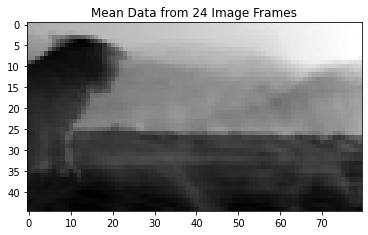

random_component: 0


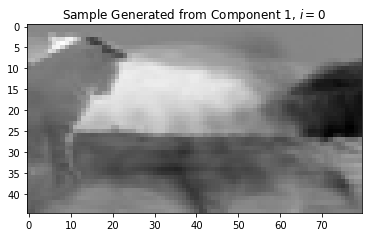

random_component: 1


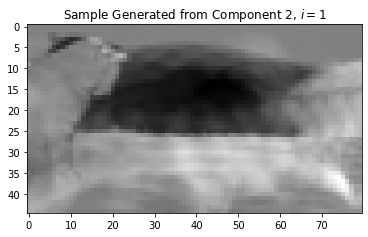

random_component: 2


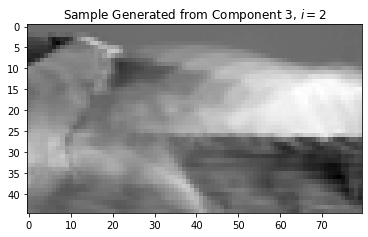

In [115]:
#random_component = np.random.choice(range(3), p=pi_list)
plt.imshow(meanData[:,0].reshape(x,y),cmap='gray')
plt.title('Mean Data from 24 Image Frames')
plt.savefig('MP2Figures/Sample MeanData.jpg', dpi=240, bbox_inches='tight')
plt.show()
for i in range(3):
    random_component=i
    print('random_component:',random_component)

    random_sample = np.random.multivariate_normal(
        mean=mu_list[random_component], 
        cov=sigma_list[random_component]
    )

#    print('random_sample:',random_sample)
    reconstructed_random_sample = pca.inverse_transform(random_sample)
#    print(reconstructed_random_sample.shape)
#    print('reconstructed_random_sample',reconstructed_random_sample.shape)
    plt.imshow(
        (reconstructed_random_sample+meanData[0]).reshape(45,80),
        cmap='gray'
    )
    plt.title('Sample Generated from Component '+str(i+1)+', $i=$'+str(i))
    plt.savefig('MP2Figures/Sample '+str(i)+' Generated Sample Mean Center.jpg', dpi=240, bbox_inches='tight')
    plt.show()

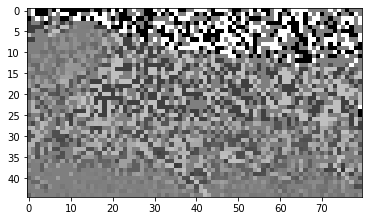

In [53]:
plt.imshow(pca.inverse_transform(np.zeros(2)).reshape(45,80), cmap='binary')

In [54]:
max(pca.inverse_transform(np.zeros(2)))

9.473903143468002e-15